In [210]:
# %load_ext autoreload
# %autoreload 2


In [57]:
import warnings
warnings.filterwarnings("ignore")

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from joblib import load

from logger import logger
# from utils import evaluate_binary, log_mlflow

In [59]:
from typing import Dict, Any, Tuple
from typing import Optional
from pathlib import Path

import matplotlib.pyplot as plt
import mlflow
import numpy as np
from joblib import dump
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score
import yaml
from logger import logger


def plot_roc(y_true: np.ndarray, y_pred: np.ndarray, model_name: str, plot_dir: str = None) -> str:
    """
    Plot the area under curve for the ROC curve.

    Args:
        y_true: Array of true y values
        y_pred: Array of predicted y values
        model_name: Name of model
        plot_dir: Directory to save plot in

    Returns:
        Output path of plot
    """
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    plt.grid()
    plt.plot(fpr, tpr, color='b')
    plt.title('ROC curve: {}'.format(model_name))
    Path(f"{plot_dir}\\plots").mkdir(parents=True, exist_ok=True)
    # Save figure
    if plot_dir:
        output_path = '{}\\plots\\roc_curve_{}.png'.format(plot_dir, model_name)
        plt.savefig(output_path)
        logger.info('ROC curve saved to: {}'.format(output_path))
        return output_path


def plot_precision_recall(y_true: np.ndarray, y_pred: np.ndarray, model_name: str, plot_dir: str = None) -> str:
    """
    Plots the precision-recall curve.

    Args:
        y_true: Array of true y values
        y_pred: Array of predicted y values
        model_name: Name of model
        plot_dir: Directory to save plot in

    Returns:Ø
        Output path of plot
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    plt.figure(figsize=(15, 5))
    plt.grid()
    plt.plot(thresholds, precision[1:], color='r', label='Precision')
    plt.plot(thresholds, recall[1:], color='b', label='Recall')
    plt.gca().invert_xaxis()
    plt.legend()
    plt.title('Precision-recall curve: {}'.format(model_name))
    Path(f"{plot_dir}\\plots").mkdir(parents=True, exist_ok=True)
    # Save figure
    if plot_dir:
        output_path = '{}/plots/precision_recall_{}.png'.format(plot_dir, model_name)
        
        plt.savefig(output_path)
        logger.info('Precision-recall curve saved to: {}'.format(output_path))
        return output_path


def save_model(model: Any, model_name: str, model_dir: str) -> str:
    """
    Saves model in pickle format

    Args:
        model: Model binary
        model_name: Name of model
        model_dir: Directory to save model in

    Returns:
        Output path of model
    """
    Path(f"{model_dir}/models").mkdir(parents=True, exist_ok=True)
    output_path = '{}/models/{}.pickle'.format(model_dir, model_name)
    logger.info('Model saved to: {}'.format(output_path))
    dump(model, output_path)

    return output_path


def evaluate_binary(y_true: np.ndarray, y_pred: np.ndarray, threshold: float = 0.5) -> \
        Tuple[float, float, float, float]:
    """
    Returns binary evaluation metrics

    Args:
        y_true: Array of true y values
        y_pred: Array of predicted y values
        threshold: Threshold to convert probabilies to binary values (default=0.5)

    Returns:
        Metrics for AUC, recall, precision, and F1
    """
    y_pred_thresholded = np.where(y_pred > threshold, 1, 0)

    auc = roc_auc_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred_thresholded)
    precision = precision_score(y_true, y_pred_thresholded)
    f1 = f1_score(y_true, y_pred_thresholded)

    logger.info('AUC: {:.3f} | Recall: {:.3f} | Precision: {:.3f} | F1: {:.3f}'.format(auc, recall, precision, f1))
    return auc, recall, precision, f1


def save_metrics(auc,recall, precision,f1, metrics_dir: str, metrics_name:str)-> None:
    # Calculate metrics
    metrics = {}

    metrics["auc"] = float(auc)
    metrics["precision"] = float(precision)
    metrics["recall"] = float(recall)
    metrics["f1"] = float(f1)
    Path(f"{metrics_dir}/metrics").mkdir(parents=True, exist_ok=True)
    output_path = f"{metrics_dir}\\metrics\\{metrics_name}_mertics.yaml"
    logger.info('Model metrics to: {}'.format(output_path))
    with open(output_path, 'w+') as file:
        yaml.dump(metrics, file, default_flow_style=False)
        
def log_mlflow(run_params: Dict, model: Any, model_name: str, y_true: np.ndarray, y_pred: np.ndarray) -> None:
    """
    Logs result of model training and validation to mlflow

    Args:
        run_params: Dictionary containing parameters of run.
                    Expects keys for 'experiment', 'artifact_dir', 'iteration', and 'index.
        model: Model binary
        model_name: Name of model
        y_true: Array of true y values
        y_pred: Array of predicted y values

    Returns:
        None
    """
    mlflow.set_experiment(run_params['experiment'])

    auc, recall, precision, f1 = evaluate_binary(y_true, y_pred)
    
    save_metrics(auc,recall ,precision,f1, metrics_dir= run_params['artifact_dir'],metrics_name =model_name+ "_" +run_params["index"])

    roc_path = plot_roc(y_true, y_pred, '{} (auc = {:.2f})'.format(model_name, auc), run_params['artifact_dir'])
    pr_path = plot_precision_recall(y_true, y_pred,
                                    '{} prec= {:.2f} recall= {:.2f}'.format(model_name, precision, recall),
                                    run_params['artifact_dir'])
    model_path = save_model(model, model_name, run_params['artifact_dir'])
    print(model_path)
    with mlflow.start_run(run_name=run_params['iteration']):
        mlflow.log_param('index', run_params['index'])
        mlflow.log_param('model', model_name)
        mlflow.log_metric('auc', auc)
        mlflow.log_metric('recall', recall)
        mlflow.log_metric('precision', precision)
        mlflow.log_metric('f1', f1)
        mlflow.log_artifact(model_path)
        mlflow.log_artifact(roc_path)
        mlflow.log_artifact(pr_path)


In [60]:

def find_project_root() -> Optional[Path]:
    current = Path(".").resolve()
    
    while True:
        if (current / ".git").exists():
            return current
        
        if current.parent == current:
            print("WARNING: No .git dir found")
            return current
              
        current = current.parent
        

PROJECT_ROOT = find_project_root()
PROJECT_ROOT

WindowsPath('C:/Users/Harsha/Documents/neustar/ospoc-mlops')

In [61]:
# Tag this cell as 'parameters'
# BASE
INDEX = 'SNP'
EXPERIMENT = 'stock_up_down'  # Name of experiment
RUN_NAME = 'initial_assessment'  # Name of iteration (that will show
ARTIFACT_DIR = PROJECT_ROOT / 'artifact_dir'  # Dir for notebook outputs where plots are saved

# Logestic Regression
FIT_INTERCEPT= False

# SVM
GAMMA=2
C_VALUE=1
PROBABILITY=True

# K-neighbour
N_NEIGHBORS = 5

# Gradient boosting Classifier
N_ESTIMATORS = 100

In [62]:
ARTIFACT_DIR

WindowsPath('C:/Users/Harsha/Documents/neustar/ospoc-mlops/artifact_dir')

In [63]:
# Wrap all this is a parameter dict
run_params = {'experiment': EXPERIMENT,
              'iteration': RUN_NAME,
              'index': INDEX,
              'artifact_dir': ARTIFACT_DIR}

### Import data

In [64]:
df = pd.read_csv(f'{PROJECT_ROOT}\\datadir\\input/{INDEX}.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-04,2814.370117,2816.879883,2767.659912,2792.810059,2792.810059,3919810000
1,2019-03-05,2794.409912,2796.439941,2782.969971,2789.649902,2789.649902,3585690000
2,2019-03-06,2790.270020,2790.270020,2768.689941,2771.449951,2771.449951,3786600000
3,2019-03-07,2766.530029,2767.250000,2739.090088,2748.929932,2748.929932,3904860000
4,2019-03-08,2730.790039,2744.129883,2722.270020,2743.070068,2743.070068,3423130000


### Data prep

In [65]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

In [66]:
df.sort_values(by='date', ascending=True, inplace=True)  # Have to sort ascending for rolling to work correctly

In [67]:
df['date'] =  pd.to_datetime(df['date'])

### Create basic features

In [68]:
df = df[['date', 'open', 'adj_close']].copy()

In [69]:
df['prev'] = df['adj_close'].shift(1)
df.head()

,date,open,adj_close,prev
0,2019-03-04,2814.370117,2792.810059,NaN
1,2019-03-05,2794.409912,2789.649902,2792.810059
2,2019-03-06,2790.270020,2771.449951,2789.649902
3,2019-03-07,2766.530029,2748.929932,2771.449951
4,2019-03-08,2730.790039,2743.070068,2748.929932


In [70]:
df['sma2'] = df['prev'].rolling(window=2).mean()
df['sma5'] = df['prev'].rolling(window=5).mean()
df['sma10'] = df['prev'].rolling(window=10).mean()
df['sma20'] = df['prev'].rolling(window=20).mean()
df.head()

,date,open,adj_close,prev,sma2,sma5,sma10,sma20
0,2019-03-04,2814.370117,2792.810059,NaN,NaN,NaN,NaN,NaN
1,2019-03-05,2794.409912,2789.649902,2792.810059,NaN,NaN,NaN,NaN
2,2019-03-06,2790.270020,2771.449951,2789.649902,2791.229981,NaN,NaN,NaN
3,2019-03-07,2766.530029,2748.929932,2771.449951,2780.549926,NaN,NaN,NaN
4,2019-03-08,2730.790039,2743.070068,2748.929932,2760.189941,NaN,NaN,NaN


In [71]:
assert round(df['prev'].tail(5).mean(), 4) == round(df['sma5'].tail(1).item(), 4), 'Expected sma5 to be same as mean of past 5 items'
assert round(df['prev'].tail(10).mean(), 4) == round(df['sma10'].tail(1).item(), 4), 'Expected sma10 to be same as mean of past 10 items'
assert round(df['prev'].tail(20).mean(), 4) == round(df['sma20'].tail(1).item(), 4), 'Expected sma20 to be same as mean of past 20 items'

In [72]:
df['ema12'] = df['prev'].ewm(span=12, min_periods=12, adjust=False).mean()
df['ema26'] = df['prev'].ewm(span=26, min_periods=26, adjust=False).mean()

In [73]:
def difference(prev_price, moving_average):
    return (prev_price - moving_average) / prev_price

In [74]:
for col in ['sma2', 'sma5', 'sma10', 'sma20', 'ema12', 'ema26']:
    df['{}_diff'.format(col)] = difference(df['prev'], df[col])

In [75]:
df.dropna(inplace=True)

In [76]:
df.shape

(227, 16)

In [77]:
# df.drop(columns=['date', 'open'], inplace=True)

### Create label

In [78]:
df['label'] = (df['adj_close'] > df['prev']).astype(int)
df.reset_index(inplace = True)
df.drop(['index'], axis=1)


,date,open,adj_close,prev,sma2,sma5,sma10,sma20,ema12,ema26,sma2_diff,sma5_diff,sma10_diff,sma20_diff,ema12_diff,ema26_diff,label
0,2019-04-09,2886.580078,2878.199951,2895.770020,2894.255005,2881.707959,2854.939966,2836.324475,2857.694399,2834.246964,0.000523,0.004856,0.014100,0.020528,0.013149,0.021246,0
1,2019-04-10,2881.370117,2888.209961,2878.199951,2886.984986,2883.899951,2860.913965,2840.658471,2860.849100,2837.502741,-0.003052,-0.001980,0.006006,0.013043,0.006028,0.014140,1
2,2019-04-11,2891.919922,2888.320068,2888.209961,2883.204956,2886.861963,2869.197949,2844.522973,2865.058463,2841.258831,0.001733,0.000467,0.006583,0.015126,0.008016,0.016256,1
3,2019-04-12,2900.860107,2907.409912,2888.320068,2888.265014,2888.647998,2876.485962,2848.514978,2868.637171,2844.744849,0.000019,-0.000114,0.004097,0.013781,0.006815,0.015087,1
4,2019-04-15,2908.320068,2905.580078,2907.409912,2897.864990,2891.581982,2883.786963,2852.761474,2874.602208,2849.386705,0.003283,0.005444,0.008125,0.018796,0.011284,0.019957,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,2020-02-26,3139.899902,3116.389893,3128.209961,3177.049927,3290.245947,3331.281958,3313.920972,3300.969392,3301.151853,-0.015613,-0.051798,-0.064916,-0.059367,-0.055226,-0.055285,0
223,2020-02-27,3062.540039,2978.760010,3116.389893,3122.299927,3236.293945,3307.145947,3305.928467,3272.572546,3287.465782,-0.001896,-0.038475,-0.061211,-0.060820,-0.050117,-0.054896,0
224,2020-02-28,2916.899902,2954.219971,2978.760010,3047.574951,3157.399951,3267.076953,3291.196472,3227.370618,3264.598687,-0.023102,-0.059971,-0.096791,-0.104888,-0.083461,-0.095959,0
225,2020-03-02,2974.280029,3090.229980,2954.219971,2966.489991,3080.693946,3225.104956,3274.724475,3185.347441,3241.607671,-0.004153,-0.042811,-0.091694,-0.108490,-0.078236,-0.097280,1


In [79]:
# Save FE
Path(f"{PROJECT_ROOT}\\datadir/output").mkdir(parents=True, exist_ok=True)
df.to_csv(PROJECT_ROOT / "datadir/output" / '{}.csv'.format(INDEX), index=False)

In [80]:
df = df.drop(['index'], axis=1)
df

,date,open,adj_close,prev,sma2,sma5,sma10,sma20,ema12,ema26,sma2_diff,sma5_diff,sma10_diff,sma20_diff,ema12_diff,ema26_diff,label
0,2019-04-09,2886.580078,2878.199951,2895.770020,2894.255005,2881.707959,2854.939966,2836.324475,2857.694399,2834.246964,0.000523,0.004856,0.014100,0.020528,0.013149,0.021246,0
1,2019-04-10,2881.370117,2888.209961,2878.199951,2886.984986,2883.899951,2860.913965,2840.658471,2860.849100,2837.502741,-0.003052,-0.001980,0.006006,0.013043,0.006028,0.014140,1
2,2019-04-11,2891.919922,2888.320068,2888.209961,2883.204956,2886.861963,2869.197949,2844.522973,2865.058463,2841.258831,0.001733,0.000467,0.006583,0.015126,0.008016,0.016256,1
3,2019-04-12,2900.860107,2907.409912,2888.320068,2888.265014,2888.647998,2876.485962,2848.514978,2868.637171,2844.744849,0.000019,-0.000114,0.004097,0.013781,0.006815,0.015087,1
4,2019-04-15,2908.320068,2905.580078,2907.409912,2897.864990,2891.581982,2883.786963,2852.761474,2874.602208,2849.386705,0.003283,0.005444,0.008125,0.018796,0.011284,0.019957,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,2020-02-26,3139.899902,3116.389893,3128.209961,3177.049927,3290.245947,3331.281958,3313.920972,3300.969392,3301.151853,-0.015613,-0.051798,-0.064916,-0.059367,-0.055226,-0.055285,0
223,2020-02-27,3062.540039,2978.760010,3116.389893,3122.299927,3236.293945,3307.145947,3305.928467,3272.572546,3287.465782,-0.001896,-0.038475,-0.061211,-0.060820,-0.050117,-0.054896,0
224,2020-02-28,2916.899902,2954.219971,2978.760010,3047.574951,3157.399951,3267.076953,3291.196472,3227.370618,3264.598687,-0.023102,-0.059971,-0.096791,-0.104888,-0.083461,-0.095959,0
225,2020-03-02,2974.280029,3090.229980,2954.219971,2966.489991,3080.693946,3225.104956,3274.724475,3185.347441,3241.607671,-0.004153,-0.042811,-0.091694,-0.108490,-0.078236,-0.097280,1


### Prepare dataset to store in parquet format

In [81]:
df.dtypes

date          datetime64[ns]
open                 float64
adj_close            float64
prev                 float64
sma2                 float64
sma5                 float64
sma10                float64
sma20                float64
ema12                float64
ema26                float64
sma2_diff            float64
sma5_diff            float64
sma10_diff           float64
sma20_diff           float64
ema12_diff           float64
ema26_diff           float64
label                  int32
dtype: object

In [82]:

predictors_df = df.loc[:,df.columns!="label"]
target_df = df[["label","date"]]

datalen = len(df)
idslist= list(range(datalen))

record_ids = pd.DataFrame(data = idslist, columns = ["record_id"])

predictors_df = pd.concat(objs = [predictors_df, record_ids], axis = 1)
target_df = pd.concat(objs = [target_df, record_ids], axis = 1)

predictors_df.rename(columns = {'date':'event_timestamp'}, inplace = True)
target_df.rename(columns = {'date':'event_timestamp'}, inplace = True)

In [83]:
target_df.head()
target_df.dtypes

label                       int32
event_timestamp    datetime64[ns]
record_id                   int64
dtype: object

In [84]:
predictors_df.to_parquet(path=f"{PROJECT_ROOT}/datadir/output/predictors_df.parquet")
target_df.to_parquet(path=f"{PROJECT_ROOT}/datadir/output/target_df.parquet", index=False)

In [85]:
# !pip install feast==0.23.3
predictors_df.head()
predictors_df.dtypes

event_timestamp    datetime64[ns]
open                      float64
adj_close                 float64
prev                      float64
sma2                      float64
sma5                      float64
sma10                     float64
sma20                     float64
ema12                     float64
ema26                     float64
sma2_diff                 float64
sma5_diff                 float64
sma10_diff                float64
sma20_diff                float64
ema12_diff                float64
ema26_diff                float64
record_id                   int64
dtype: object

In [86]:
import feast
print(f"feast SDK version: {feast.__version__}")

feast SDK version: 0.27.1


In [87]:
from feast import FeatureStore
from feast.infra.offline_stores.file_source import SavedDatasetFileStorage

store = FeatureStore(repo_path=f'{PROJECT_ROOT}/feature_repo/')

entity_df = pd.read_parquet(path = f'{PROJECT_ROOT}/datadir/output/target_df.parquet')

training_data = store.get_historical_features(
entity_df = entity_df,
    features = [
        "predictors_df_feature_view:prev",
        "predictors_df_feature_view:sma2",
        "predictors_df_feature_view:sma5",
        "predictors_df_feature_view:sma10",
        "predictors_df_feature_view:sma20",
        "predictors_df_feature_view:ema12",
        "predictors_df_feature_view:ema26",
        "predictors_df_feature_view:sma2_diff",
        "predictors_df_feature_view:sma5_diff",
        "predictors_df_feature_view:sma10_diff",
        "predictors_df_feature_view:sma20_diff",
        "predictors_df_feature_view:ema12_diff",
        "predictors_df_feature_view:ema26_diff",
        "predictors_df_feature_view:adj_close",
        
               ]
)

### Genrate Training data
storage_path  = f'{PROJECT_ROOT}\\feature_repo\\data\\stock_dataset.parquet'
# Instantiate the Path class
obj = Path(storage_path)
obj.unlink(missing_ok=True)

dataset = store.create_saved_dataset(
from_=training_data,
    name = "stocks_dataset",
    storage = SavedDatasetFileStorage(storage_path)
)

In [88]:
print(f'{PROJECT_ROOT}\\datadir\\output\\stock_dataset.parquet')

C:\Users\Harsha\Documents\neustar\ospoc-mlops\datadir\output\stock_dataset.parquet


In [89]:
df = training_data.to_df()
df = df.drop(['event_timestamp','record_id'], axis=1)

In [90]:
df.head()

,label,prev,sma2,sma5,sma10,sma20,ema12,ema26,sma2_diff,sma5_diff,sma10_diff,sma20_diff,ema12_diff,ema26_diff,adj_close
0,0,2895.770020,2894.255005,2881.707959,2854.939966,2836.324475,2857.694399,2834.246964,0.000523,0.004856,0.014100,0.020528,0.013149,0.021246,2878.199951
1,1,2878.199951,2886.984986,2883.899951,2860.913965,2840.658471,2860.849100,2837.502741,-0.003052,-0.001980,0.006006,0.013043,0.006028,0.014140,2888.209961
2,1,2888.209961,2883.204956,2886.861963,2869.197949,2844.522973,2865.058463,2841.258831,0.001733,0.000467,0.006583,0.015126,0.008016,0.016256,2888.320068
3,1,2888.320068,2888.265014,2888.647998,2876.485962,2848.514978,2868.637171,2844.744849,0.000019,-0.000114,0.004097,0.013781,0.006815,0.015087,2907.409912
4,0,2907.409912,2897.864990,2891.581982,2883.786963,2852.761474,2874.602208,2849.386705,0.003283,0.005444,0.008125,0.018796,0.011284,0.019957,2905.580078


### Train-val split

In [91]:
# Keep most recent 20 days as validation set

In [92]:
validation_days = 20
train = df.iloc[:-validation_days].copy()
val = df.iloc[-validation_days:].copy()
logger.info('No. of days - Train: {}, Val: {}'.format(train.shape[0], val.shape[0]))

2023-01-02 10:51:43,308 - No. of days - Train: 207, Val: 20


### Basic visualizations

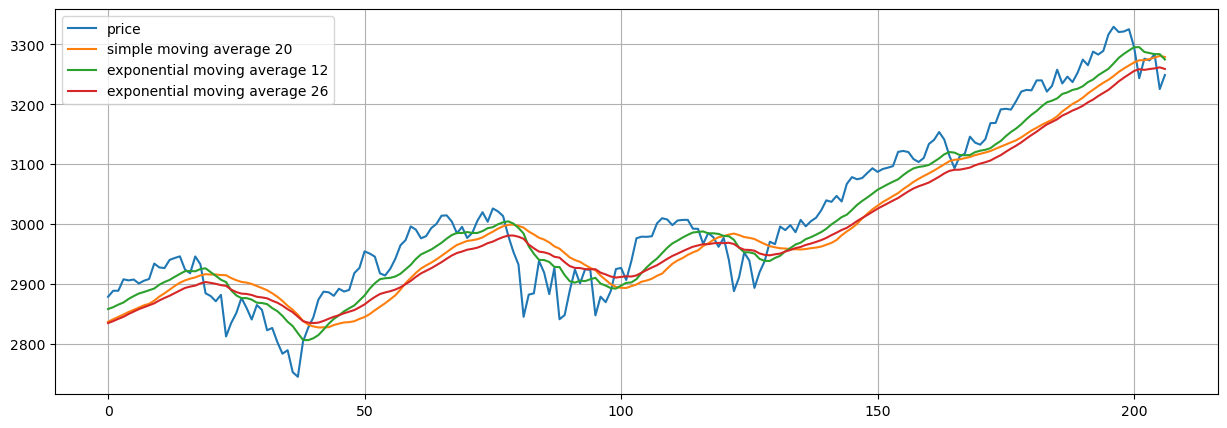

In [93]:
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(train['adj_close'], label='price')
plt.plot(train['sma20'], label='simple moving average 20')
plt.plot(train['ema12'], label='exponential moving average 12')
plt.plot(train['ema26'], label='exponential moving average 26')
plt.legend()

### Feature transformations

In [94]:
scaler = StandardScaler()

In [95]:
COLS_TO_SCALE = ['prev', 'sma2', 'sma5', 'sma10', 'sma20', 'ema12', 'ema26']

In [96]:
scaler.fit(train[COLS_TO_SCALE])

StandardScaler()

In [97]:
train[COLS_TO_SCALE] = scaler.transform(train[COLS_TO_SCALE])
val[COLS_TO_SCALE] = scaler.transform(val[COLS_TO_SCALE])

### Linear regression coefficients

In [98]:
x_variables = '+'.join(list(train.columns[1:-1]))
logger.info('x variables: {}'.format(x_variables))

2023-01-02 10:51:47,045 - x variables: prev+sma2+sma5+sma10+sma20+ema12+ema26+sma2_diff+sma5_diff+sma10_diff+sma20_diff+ema12_diff+ema26_diff


In [99]:
results = smf.ols('adj_close ~ {}'.format(x_variables), data=train).fit()

In [100]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              adj_close   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     578.1
Date:                Mon, 02 Jan 2023   Prob (F-statistic):          8.72e-147
Time:                        10:51:47   Log-Likelihood:                -930.76
No. Observations:                 207   AIC:                             1890.
Df Residuals:                     193   BIC:                             1936.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3041.1045     46.445     65.478      0.0

### Drop label col

In [45]:
train.drop(columns=['adj_close'], inplace=True)
val.drop(columns=['adj_close'], inplace=True)

### Logistic Regression Coefficients

In [46]:
y = train['label'].values
X = train.drop(columns=['label'])

In [47]:
X = add_constant(X)

In [48]:
logit = sm.Logit(y, X)

In [49]:
result = logit.fit()
print(result.summary())

         Current function value: 1.780240
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  207
Model:                          Logit   Df Residuals:                      193
Method:                           MLE   Df Model:                           13
Date:                Mon, 02 Jan 2023   Pseudo R-squ.:                  -1.617
Time:                        10:33:53   Log-Likelihood:                -368.51
converged:                      False   LL-Null:                       -140.84
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.3716     15.369      4.188      0.000      34.249      94.494
prev        -596.4932    150.250     -3.970      0.000    -890.97

C:\Users\Harsha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Train some basic models

In [50]:
y_train = train['label'].values
X_train = train.drop(columns='label').values

y_val = val['label'].values
X_val = val.drop(columns='label').values

In [51]:
#python program to check if a directory exists
import os
path = run_params["artifact_dir"]
# Check whether the specified path exists or not
isExist = os.path.exists(path)
isExist
# if not isExist:

#    # Create a new directory because it does not exist
#    os.makedirs(path)
#    print("The new directory is created!")

True

2023-01-02 10:33:55,440 - AUC: 0.303 | Recall: 0.889 | Precision: 0.444 | F1: 0.593
2023-01-02 10:33:55,440 - Model metrics to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir\metrics\Logistic_Regression_SNP_mertics.yaml
2023-01-02 10:33:55,617 - ROC curve saved to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir\plots\roc_curve_Logistic_Regression (auc = 0.30).png
2023-01-02 10:33:55,825 - Precision-recall curve saved to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir/plots/precision_recall_Logistic_Regression prec= 0.44 recall= 0.89.png
2023-01-02 10:33:55,825 - Model saved to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir/models/Logistic_Regression.pickle


C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir/models/Logistic_Regression.pickle


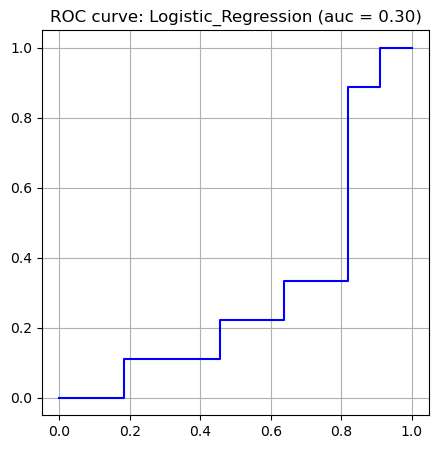

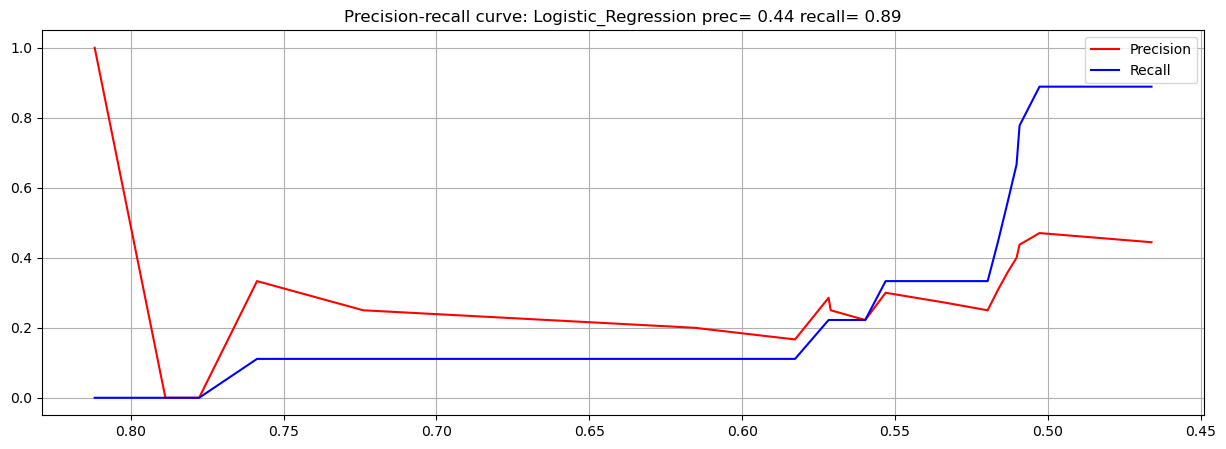

In [52]:
# Logistic regression
model_name = 'Logistic_Regression'
model = LogisticRegression(fit_intercept=FIT_INTERCEPT).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

2023-01-02 10:33:56,787 - AUC: 0.707 | Recall: 1.000 | Precision: 0.450 | F1: 0.621
2023-01-02 10:33:56,795 - Model metrics to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir\metrics\Support Vector Classifier_SNP_mertics.yaml
2023-01-02 10:33:56,933 - ROC curve saved to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir\plots\roc_curve_Support Vector Classifier (auc = 0.71).png
2023-01-02 10:33:57,138 - Precision-recall curve saved to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir/plots/precision_recall_Support Vector Classifier prec= 0.45 recall= 1.00.png
2023-01-02 10:33:57,145 - Model saved to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir/models/Support Vector Classifier.pickle


C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir/models/Support Vector Classifier.pickle


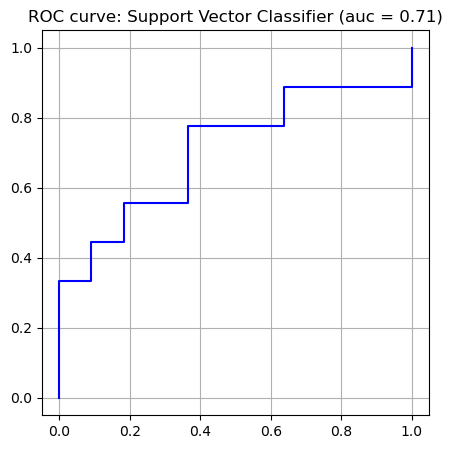

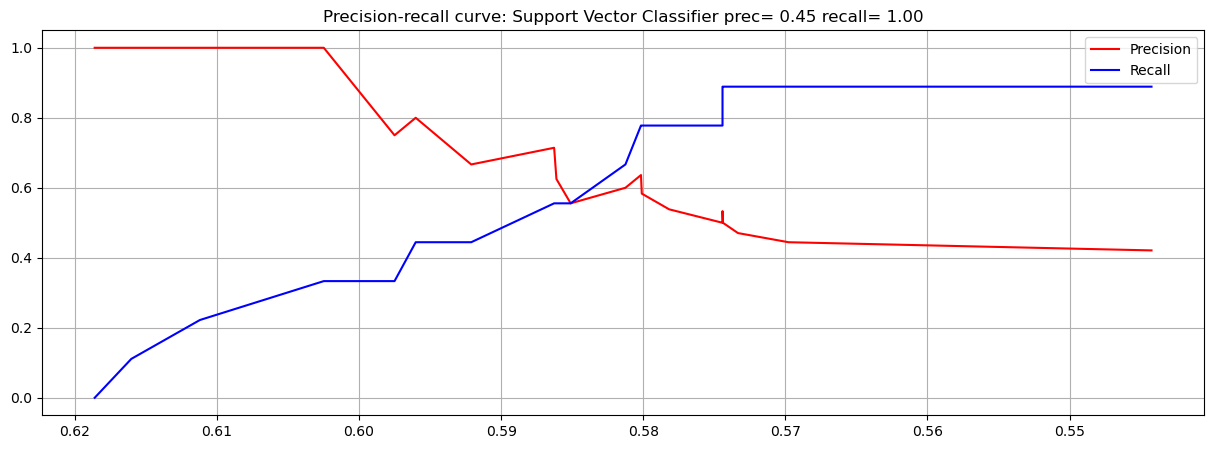

In [53]:
# Support vector classifier
model_name = 'Support Vector Classifier'
model = SVC(gamma=GAMMA, C=C_VALUE, probability=PROBABILITY).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)



2023-01-02 10:33:57,656 - AUC: 0.480 | Recall: 0.333 | Precision: 0.429 | F1: 0.375
2023-01-02 10:33:57,664 - Model metrics to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir\metrics\K-nearest Neighbours_SNP_mertics.yaml
2023-01-02 10:33:57,826 - ROC curve saved to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir\plots\roc_curve_K-nearest Neighbours (auc = 0.48).png
2023-01-02 10:33:58,036 - Precision-recall curve saved to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir/plots/precision_recall_K-nearest Neighbours prec= 0.43 recall= 0.33.png
2023-01-02 10:33:58,036 - Model saved to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir/models/K-nearest Neighbours.pickle


C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir/models/K-nearest Neighbours.pickle


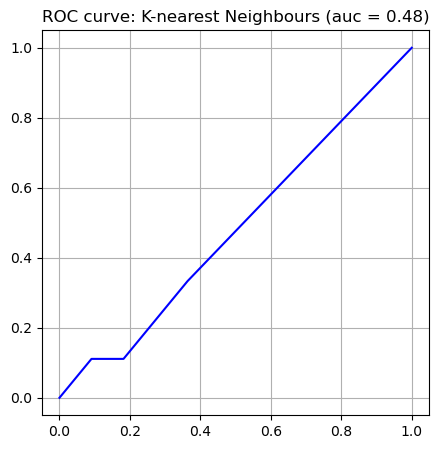

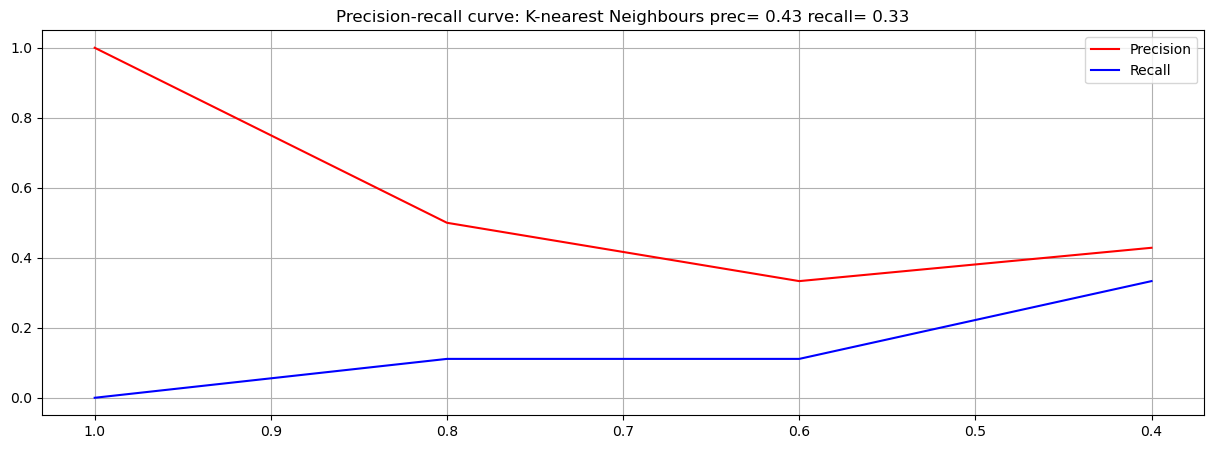

In [54]:
# K-neighbours
model_name = 'K-nearest Neighbours'
model = KNeighborsClassifier(n_neighbors=N_NEIGHBORS).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)


2023-01-02 10:33:58,703 - AUC: 0.323 | Recall: 0.222 | Precision: 0.250 | F1: 0.235
2023-01-02 10:33:58,705 - Model metrics to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir\metrics\Gradient Boosting Machine_SNP_mertics.yaml
2023-01-02 10:33:58,832 - ROC curve saved to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir\plots\roc_curve_Gradient Boosting Machine (auc = 0.32).png
2023-01-02 10:33:59,055 - Precision-recall curve saved to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir/plots/precision_recall_Gradient Boosting Machine prec= 0.25 recall= 0.22.png
2023-01-02 10:33:59,058 - Model saved to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir/models/Gradient Boosting Machine.pickle


C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir/models/Gradient Boosting Machine.pickle


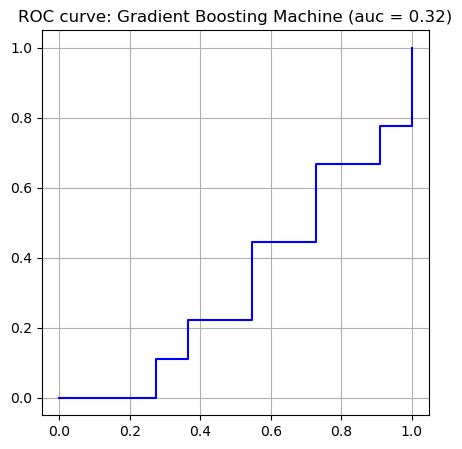

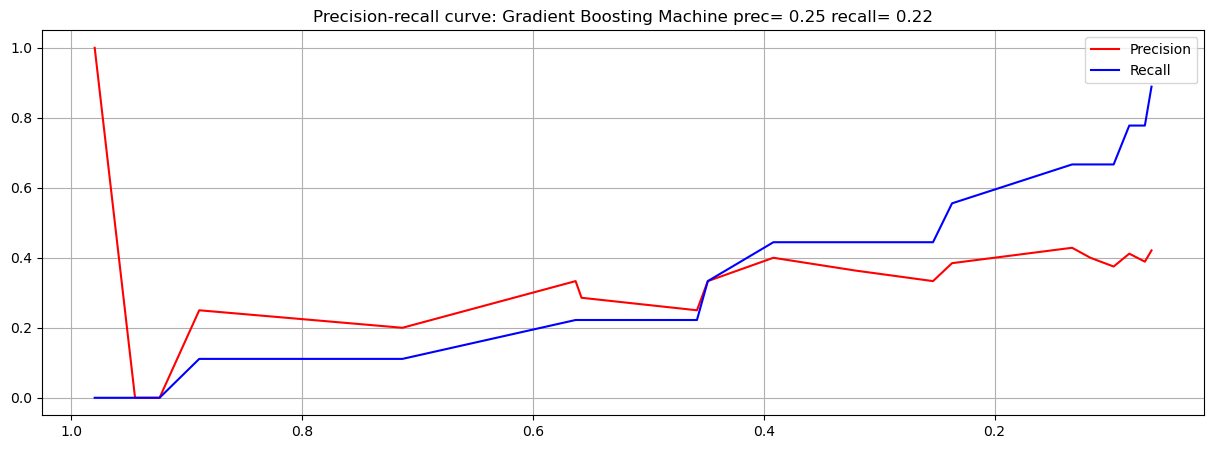

In [55]:
# Gradient Boosting
model_name = 'Gradient Boosting Machine'
model = GradientBoostingClassifier(n_estimators=N_ESTIMATORS).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

2023-01-02 10:33:59,683 - AUC: 0.429 | Recall: 0.333 | Precision: 0.375 | F1: 0.353
2023-01-02 10:33:59,683 - Model metrics to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir\metrics\Extra Trees_SNP_mertics.yaml
2023-01-02 10:33:59,844 - ROC curve saved to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir\plots\roc_curve_Extra Trees (auc = 0.43).png
2023-01-02 10:34:00,103 - Precision-recall curve saved to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir/plots/precision_recall_Extra Trees prec= 0.38 recall= 0.33.png
2023-01-02 10:34:00,103 - Model saved to: C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir/models/Extra Trees.pickle


C:\Users\Harsha\Documents\neustar\ospoc-mlops\artifact_dir/models/Extra Trees.pickle


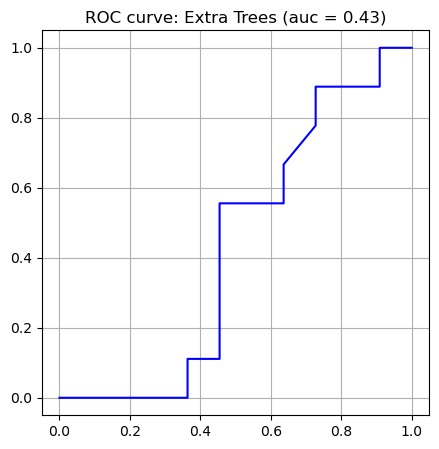

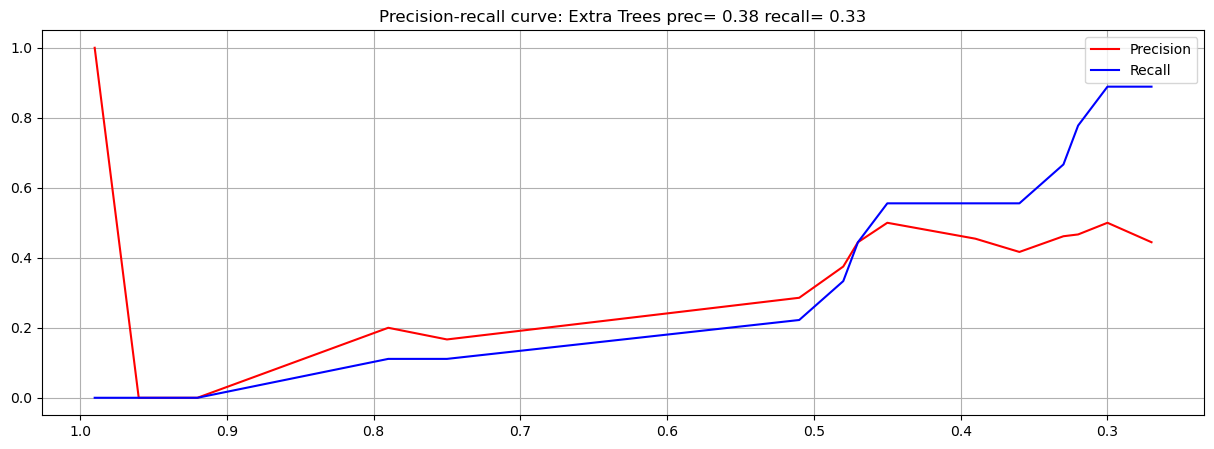

In [56]:
# Bagged trees
model_name = 'Extra Trees'
model = ExtraTreesClassifier().fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

### Test loading model

In [270]:
model_name = 'Support Vector Classifier'
check_model = load('{}/models/{}.pickle'.format(ARTIFACT_DIR, model_name))

In [271]:
check_model

SVC(C=1, gamma=2, probability=True)

In [272]:
pred = check_model.predict_proba(X_val)[:, 1]

In [273]:
evaluate_binary(y_val, pred)

2022-12-31 01:12:34,657 - AUC: 0.707 | Recall: 1.000 | Precision: 0.450 | F1: 0.621


(0.7070707070707071, 1.0, 0.45, 0.6206896551724138)